## Overview

In this project, the aim is to develop and compare machine learning models for the classification of FIFA21 players based on their Overall Rating (OVA). Utilizing a diverse set of player attributes ranging from physical attributes like Pace and Strength to skill-based metrics like Dribbling and Shooting, the objective is to construct models capable of accurately categorizing players into predefined OVA categories: Low, Medium, and High. Through the utilization of Convolutional Neural Networks (CNNs), Long Short-Term Memory (LSTM) networks, and Recurrent Neural Networks (RNNs), we explore the efficacy of various deep learning architectures in capturing spatial and sequential patterns within the FIFA21 player data, ultimately aiming to discern the most effective approach for player classification.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN

pd.set_option('display.max_columns', None)

# Suppress warnings
warnings.filterwarnings("ignore")

## Import Dataset

In [2]:
df = pd.read_csv('df_cleaned.csv')
df[['Age Group']].value_counts()

Age Group  
Youth          9198
Prime          6055
Experienced    3726
dtype: int64

## Initial Data Preprocessing

### Data Discretization and Binning

* **Objective**: The goal of this step is to categorize OVA values into meaningful bins with labels to simplify subsequent analysis.

* **Method**: Custom bins and labels are defined as follows: [0, 60, 70, 100] with labels 'Low,' 'Medium,' and 'High,' respectively.

* **Insight**: This discretization transforms continuous OVA values into three distinct categories, providing a foundation for classification tasks. It simplifies the prediction task by converting OVA into ordinal classes.

In [3]:
# Define custom bins and labels for categories
bins = [0, 60, 70, 100] 
labels = ['Low', 'Medium', 'High']

# Use pd.cut to categorize the OVA values
df['OVA'] = pd.cut(df['OVA'], bins=bins, labels=labels)
df

,Nationality,Age Group,OVA,Potential Rating,Club,Contract Duration (Years),Positions,Height,Weight,Preferred Foot,Sprint Speed,Reactions,Jumping,Stamina,Strength,Aggression,Vision,Composure,Skill Moves Rating,Attacking Work Rate,Defensive Work Rate,Pace,Shooting,Passing,Dribbling,Defending,Market Value
0,Argentina,Experienced,High,93,FC Barcelona,9.5,"RW, ST, CF",170.0,72.0,0,80,94,68,72,69,44,95,96,4,Medium,Low,85,92,91,95,38,103500000.0
1,Portugal,Experienced,High,92,Juventus,4.0,"ST, LW",187.0,83.0,1,91,95,95,84,78,63,82,95,5,High,Low,89,93,81,89,35,63000000.0
2,Slovenia,Prime,High,93,Atlético Madrid,9.0,GK,188.0,87.0,1,60,88,78,41,78,34,65,68,1,Medium,Medium,87,92,78,90,52,120000000.0
3,Belgium,Prime,High,91,Manchester City,8.0,"CAM, CM",181.0,70.0,1,76,91,63,89,74,76,94,91,4,High,High,76,86,93,88,64,129000000.0
4,Brazil,Prime,High,91,Paris Saint-Germain,5.0,"LW, CAM",175.0,68.0,1,89,91,62,81,50,51,90,93,5,High,Medium,91,85,86,94,36,132000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18974,China PR,Youth,Low,55,Wuhan Zall,4.0,CB,178.0,66.0,1,60,46,57,54,50,48,28,44,2,Medium,Medium,64,28,26,38,48,100000.0
18975,England,Youth,Low,67,Oldham Athletic,1.0,CM,175.0,65.0,1,64,51,58,43,47,40,47,38,2,Medium,Medium,64,40,48,49,35,130000.0
18976,England,Youth,Low,65,Derry City,1.0,CM,179.0,74.0,1,66,47,52,50,54,56,43,43,2,Medium,Medium,63,39,44,46,40,120000.0
18977,China PR,Youth,Low,57,Dalian YiFang FC,2.0,RW,175.0,69.0,1,55,33,45,46,48,31,46,45,2,Medium,Medium,58,49,41,49,30,100000.0


In [4]:
df[['Age Group', 'OVA', 'Attacking Work Rate', 'Defensive Work Rate']].value_counts()

Age Group    OVA     Attacking Work Rate  Defensive Work Rate
Youth        Medium  Medium               Medium                 2517
             Low     Medium               Medium                 2471
Prime        Medium  Medium               Medium                 1810
Experienced  Medium  Medium               Medium                 1072
Youth        Medium  High                 Medium                  861
                                                                 ... 
Prime        Low     Low                  Low                       4
Experienced  Low     Low                  Low                       4
Prime        High    Low                  Low                       3
Experienced  High    Low                  Low                       2
Youth        High    Low                  Low                       1
Length: 81, dtype: int64

### Data Encoding

* **Objective**: Encode categorical features into numerical values for machine learning algorithms, preserving the order of some categories.

* **Method**: 
>* **Ordinal encoding** is applied to 'Age Group' and 'OVA,' where custom orderings ('Youth' < 'Prime' < 'Experienced' and 'Low' < 'Medium' < 'High') are defined to reflect the natural order of these categories.
>* **Label encoding** is used for other categorical features like 'Nationality,' 'Club,' and 'Positions,' where no specific order exists.

* **Insight**: Encoding categorical variables ensures that all features are represented numerically, making them suitable for machine learning algorithms. Maintaining the order for 'Age Group' and 'OVA' is crucial, as it reflects the natural progression of player age and OVA ratings.

In [5]:
# Define the order of categories for each feature
age_group_order = ['Youth', 'Prime', 'Experienced']
ova_order = ['Low', 'Medium', 'High']
attacking_wr_order = ['Low', 'Medium', 'High']
defensive_wr_order = ['Low', 'Medium', 'High']

# Initialize the encoder
ordinal_encoder = OrdinalEncoder(categories=[age_group_order, ova_order, attacking_wr_order, defensive_wr_order])

# Fit the encoder to the DataFrame
df[['Age Group', 'OVA', 'Attacking Work Rate', 'Defensive Work Rate']] = ordinal_encoder.fit_transform(df[['Age Group', 'OVA', 'Attacking Work Rate', 'Defensive Work Rate']])

from sklearn.preprocessing import LabelEncoder
categorical_features = ['Nationality', 'Club', 'Positions']
for feature in categorical_features:
    label_encoder = LabelEncoder()
    df[feature] = label_encoder.fit_transform(df[feature])

### Check Correlations

* **Objective**: Evaluate the strength and direction of correlations between features and the target variable (OVA).

* **Method**: Correlation coefficients are computed to measure the linear relationship between each feature and OVA.

* **Insight**: Understanding feature correlations helps identify which features may be more relevant for predicting OVA.

In [6]:
correlations = df.corr()['OVA'].sort_values(ascending=False)
correlations

OVA                          1.000000
Reactions                    0.782784
Composure                    0.638950
Passing                      0.629458
Dribbling                    0.584125
Potential Rating             0.548567
Vision                       0.457875
Shooting                     0.424477
Market Value                 0.396824
Aggression                   0.375911
Age Group                    0.371013
Skill Moves Rating           0.349250
Stamina                      0.348283
Defending                    0.337413
Strength                     0.329065
Jumping                      0.260716
Pace                         0.233612
Sprint Speed                 0.189913
Contract Duration (Years)    0.181076
Attacking Work Rate          0.165104
Weight                       0.138943
Defensive Work Rate          0.104855
Height                       0.030861
Club                         0.014456
Positions                    0.006599
Nationality                 -0.045133
Preferred Fo

The analysis of the FIFA 21 dataset reveals that certain player attributes positively correlate with Overall Ratings (OVA), indicating that enhancements in these attributes tend to correspond with higher overall ratings. The attributes that hold the strongest positive influence include 'Reactions', 'Composure', 'Passing' and 'Dribbling'. This implies that players who exhibit quicker reactions, maintain composure under pressure, and possess proficient passing and dribbling skills are likely to have higher overall ratings.

In the development of a predictive model, the focus is on attributes with positive correlations. Attributes displaying negative correlations, such as 'Nationality' and 'Preferred Foot', are omitted from the model as they do not positively influence the overall rating based on the analysis conducted. This strategy is directed towards improving the predictive accuracy of the model by emphasizing the most significant attributes that positively affect ratings.

### Check Class Imbalance

* **Objective**: Examine the distribution of players across OVA categories to identify class imbalance.

* **Method**: A bar plot is created to visualize the count of players in each OVA category ('Low,' 'Medium,' 'High').

* **Insight**: Class imbalance can impact model performance. In this case, the bar plot shows the distribution of players across different OVA categories, highlighting whether there is a need to address class imbalance using techniques like oversampling, undersampling or SMOTE.

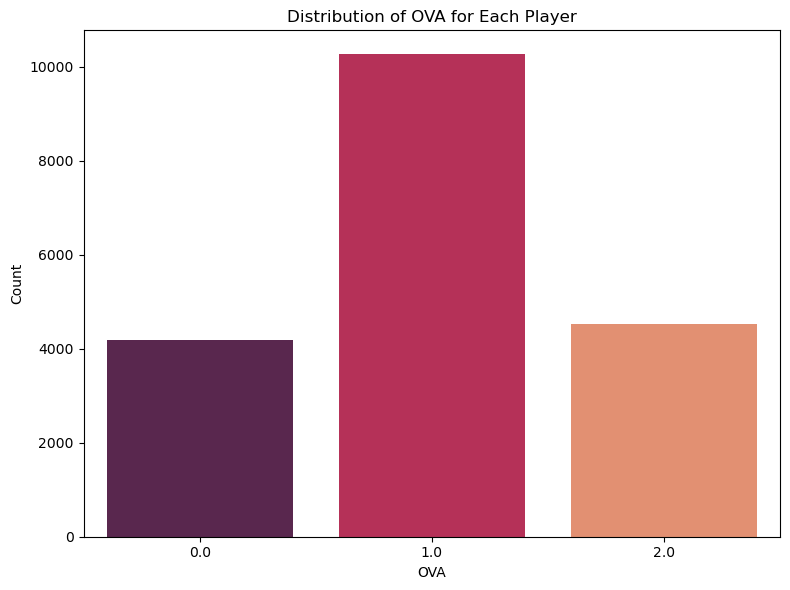

In [7]:
# Calculate the count of players in each age group
ova_group = df['OVA'].value_counts()

# Create a bar plot using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=ova_group.index, y=ova_group.values, palette="rocket")
plt.title('Distribution of OVA for Each Player')
plt.xlabel('OVA')
plt.ylabel('Count')
plt.xticks()  
plt.tight_layout();

In [8]:
ova_group

1.0    10264
2.0     4536
0.0     4179
Name: OVA, dtype: int64

The bar chart shows the distribution of FIFA 21 players' Overall Ratings (OVA) across three categories: Low(0), Medium(1), and High(2). The Medium category contains a majority of players, significantly exceeding the number in both the Low and High categories. This disparity suggests that a predictive model might be inclined to favor the Medium category when making predictions due to its larger sample size. Consequently, the model could struggle to accurately identify players who should be classified as Low or High OVA, as it has less data for these groups. To enhance the model's predictive capabilities across all categories, it is recommended to implement balancing methods, ensuring a more equitable distribution of data for the model to learn from.

### Data Splitting and Balancing

* **Objective**: Prepare the data for training and testing machine learning models, addressing class imbalance if necessary.
* **Method**:
>* The dataset is split into training and testing sets using the train_test_split function without initial balancing.
>* SMOTE (Synthetic Minority Over-sampling Technique) is applied to the training data to create synthetic samples for minority classes, balancing the class distribution.
* **Insight**: Splitting the data into training and testing sets is essential for model evaluation. Applying SMOTE ensures that the model is trained on a balanced dataset, reducing the risk of bias towards the majority class in classification tasks.

In [9]:
X = df.drop(columns=['OVA', 'Nationality', 'Preferred Foot'])
y = df['OVA']

# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [10]:
resampled_df = pd.DataFrame(y_train_resampled.value_counts())
resampled_df = resampled_df.reset_index().rename(columns={'index': 'OVA', 'OVA':'Count'})
resampled_df

,OVA,Count
0,2.0,7134
1,1.0,7134
2,0.0,7134


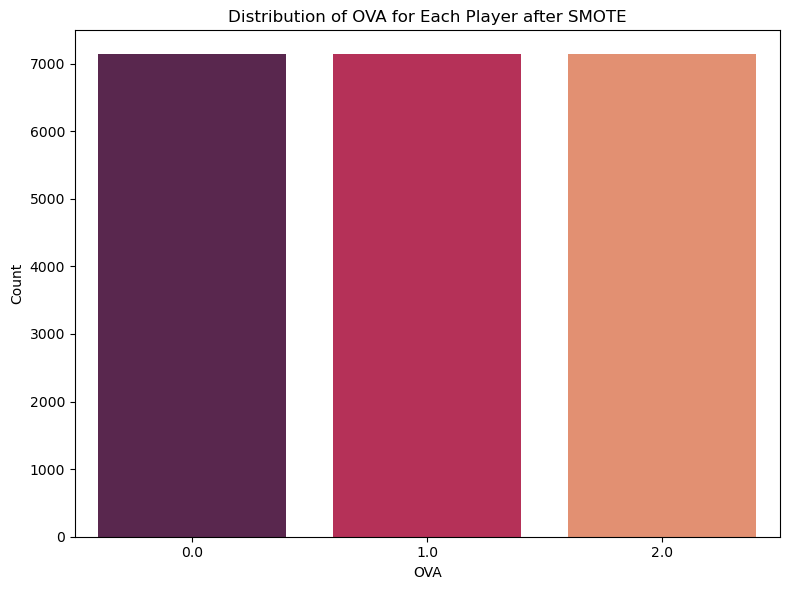

In [11]:
# Create a bar plot using seaborn to visualize class distribution after SMOTE
plt.figure(figsize=(8, 6))
sns.barplot(data=resampled_df, x='OVA', y='Count', palette="rocket")
plt.title('Distribution of OVA for Each Player after SMOTE')
plt.xlabel('OVA')
plt.ylabel('Count')
plt.xticks()  
plt.tight_layout();

The bar chart reflects a balanced distribution of player ratings in FIFA 21 after applying the SMOTE, evening out the number of players across Low(0), Medium(1), and High(2) OVA categories. Balancing the data is crucial for training a predictive model to reduce bias and ensure accurate predictions across all rating levels. However, this balancing act, while beneficial for model performance, can introduce synthetic data points that may not perfectly represent real-world scenarios, potentially leading to overfitting where the model may not perform as well on unseen data. Despite this, the balancing process is vital to ensure the model is well-rounded and reflective of the diverse player abilities.

## Methodology

**1. Data Preprocessing:**
* Reshaping Input Data: The input data (X_train_resampled and X_test) are reshaped to be suitable for each respective model's input. For CNN, it's reshaped into a 3D array with dimensions corresponding to samples, features, and channels. For LSTM and RNN, it's reshaped into a 3D array with dimensions corresponding to samples, timesteps, and features.

**2. Model Architectures:**

**CNN Model:**
* Layers: The CNN model consists of convolutional layers followed by max-pooling layers to extract spatial hierarchies of features from the input data. After flattening, fully connected layers are used for classification.
* Activation: ReLU activation is used in convolutional and dense layers, providing non-linearity.
* Regularization: Dropout regularization is applied to prevent overfitting.

**LSTM Model:**
* Layers: The LSTM model utilizes LSTM layers to capture long-term dependencies in the input data. Fully connected layers are added for classification.
* Activation: ReLU activation is used in the dense layers.
* Regularization: Dropout regularization is applied to prevent overfitting.

**RNN Model:**
* Layers: The RNN model uses Simple RNN layers to capture sequential patterns in the input data. Fully connected layers follow for classification.
* Activation: ReLU activation is used in the dense layers.
* Regularization: Dropout regularization is applied to prevent overfitting.

**3. Model Compilation:**
* All models are compiled using the Adam optimizer, which is effective for training neural networks.
* Sparse categorical crossentropy loss function is chosen for all models since the labels are integers and not one-hot encoded.
* Accuracy metric is used to monitor the performance during training.

**4. Model Training:**
* Each model is trained on the training data (X_train_) for 20 epochs.
* Validation data (X_test_) are provided to monitor the model's performance during training.

**5. Model Evaluation:**
* After training, the models' performance is evaluated on the test data using the evaluate method.
* Test accuracy is printed to assess the effectiveness of each model in classifying FIFA21 players based on their Overall Rating.

## Model 1: CNN

Convolutional Neural Networks (CNN) excel in capturing spatial relationships and hierarchies within data, making them ideal for tasks such as image recognition and text classification. In the context of FIFA21 player classification based on Overall Rating, CNNs can effectively analyze attributes like Reactions, Composure, Passing, and Dribbling, which have strong correlations with OVA. By leveraging convolutional layers to extract spatial patterns from player attributes, followed by max-pooling layers to downsample the features, CNNs can discern important features for accurately classifying players into different OVA categories.

In [12]:
#Reshape the input data for CNN
X_train_cnn = X_train_resampled.values.reshape((-1, X_train_resampled.shape[1],1))
X_test_cnn = X_test.values.reshape((-1, X_test.shape[1], 1))

#Define the CNN model
model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Low, Medium, High
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_cnn, y_train_resampled, epochs=20, validation_data=(X_test_cnn, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_cnn, y_test)
print('Test accuracy:', test_acc)

Epoch 1/20
669/669 [==============================] - 10s 11ms/step - loss: 1.0413 - accuracy: 0.5926 - val_loss: 0.6957 - val_accuracy: 0.6458
Epoch 2/20
669/669 [==============================] - 7s 11ms/step - loss: 0.6279 - accuracy: 0.7117 - val_loss: 0.5779 - val_accuracy: 0.7164
Epoch 3/20
669/669 [==============================] - 7s 10ms/step - loss: 0.5501 - accuracy: 0.7531 - val_loss: 0.6209 - val_accuracy: 0.6953
Epoch 4/20
669/669 [==============================] - 7s 10ms/step - loss: 0.5134 - accuracy: 0.7739 - val_loss: 0.4865 - val_accuracy: 0.7838
Epoch 5/20
669/669 [==============================] - 7s 10ms/step - loss: 0.4899 - accuracy: 0.7847 - val_loss: 0.5047 - val_accuracy: 0.7703
Epoch 6/20
669/669 [==============================] - 7s 10ms/step - loss: 0.4677 - accuracy: 0.7960 - val_loss: 0.4868 - val_accuracy: 0.7612
Epoch 7/20
669/669 [==============================] - 7s 10ms/step - loss: 0.4508 - accuracy: 0.8032 - val_loss: 0.4422 - val_accuracy: 0.800

## Model 2: LSTM

Long Short-Term Memory (LSTM) Networks are designed to capture long-term dependencies in sequential data, making them well-suited for tasks involving time-series data or sequences. In the context of FIFA21 player classification, LSTM networks can effectively analyze sequential attributes such as Potential Rating, Vision, and Shooting, which exhibit correlations with OVA. By processing the sequential nature of player attributes over time, LSTMs can capture trends and patterns in player performance, allowing for accurate classification into OVA categories.

In [13]:
# Reshape the input data for LSTM
X_train_lstm = X_train_resampled.values.reshape((-1, X_train_resampled.shape[1], 1))
X_test_lstm = X_test.values.reshape((-1, X_test.shape[1], 1))

# Define the LSTM model
model = models.Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], 1)),
    Dense(128, activation='relu'),
    layers.Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: Low, Medium, High
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_lstm, y_train_resampled, epochs=20, validation_data=(X_test_lstm, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_lstm, y_test)
print('Test accuracy:', test_acc)

Epoch 1/20
669/669 [==============================] - 24s 27ms/step - loss: 0.5897 - accuracy: 0.7264 - val_loss: 0.4230 - val_accuracy: 0.8170
Epoch 2/20
669/669 [==============================] - 17s 25ms/step - loss: 0.3703 - accuracy: 0.8438 - val_loss: 0.4337 - val_accuracy: 0.7973
Epoch 3/20
669/669 [==============================] - 17s 25ms/step - loss: 0.3155 - accuracy: 0.8672 - val_loss: 0.4079 - val_accuracy: 0.8242
Epoch 4/20
669/669 [==============================] - 17s 26ms/step - loss: 0.3037 - accuracy: 0.8731 - val_loss: 0.4603 - val_accuracy: 0.7857
Epoch 5/20
669/669 [==============================] - 17s 25ms/step - loss: 0.2874 - accuracy: 0.8808 - val_loss: 0.3269 - val_accuracy: 0.8539
Epoch 6/20
669/669 [==============================] - 17s 25ms/step - loss: 0.2807 - accuracy: 0.8835 - val_loss: 0.3057 - val_accuracy: 0.8692
Epoch 7/20
669/669 [==============================] - 17s 25ms/step - loss: 0.2609 - accuracy: 0.8921 - val_loss: 0.2597 - val_accuracy:

## Model 3: RNN

Recurrent Neural Networks (RNNs) including Simple RNNs, are adept at processing sequences of data by maintaining a hidden state that evolves over time. They are widely used in tasks involving sequential data analysis, such as language modeling, time-series forecasting, and sentiment analysis. In the context of FIFA21 player classification, RNNs can effectively analyze attributes like Stamina, Defending, and Strength, which show correlations with OVA. By capturing sequential patterns in player attributes and historical performance trends, RNNs can provide valuable insights for accurately classifying players into different OVA categories.

In [14]:
# Reshape the input data for RNN
X_train_rnn = X_train_resampled.values.reshape((-1, X_train_resampled.shape[1], 1))
X_test_rnn = X_test.values.reshape((-1, X_test.shape[1], 1))

# Define the RNN model
model = models.Sequential([
    SimpleRNN(64, input_shape=(X_train_rnn.shape[1], 1), activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Low, Medium, High
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_rnn, y_train_resampled, epochs=20, validation_data=(X_test_rnn, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_rnn, y_test)
print('Test accuracy:', test_acc)


Epoch 1/20
669/669 [==============================] - 11s 13ms/step - loss: 11428.6611 - accuracy: 0.5768 - val_loss: 5.5000 - val_accuracy: 0.7027
Epoch 2/20
669/669 [==============================] - 8s 12ms/step - loss: 2.5296 - accuracy: 0.3845 - val_loss: 1.1326 - val_accuracy: 0.5486
Epoch 3/20
669/669 [==============================] - 8s 12ms/step - loss: 1.1614 - accuracy: 0.3410 - val_loss: 1.0900 - val_accuracy: 0.5529
Epoch 4/20
669/669 [==============================] - 8s 12ms/step - loss: 1.0954 - accuracy: 0.3381 - val_loss: 1.0862 - val_accuracy: 0.5595
Epoch 5/20
669/669 [==============================] - 8s 12ms/step - loss: 1.0681 - accuracy: 0.3777 - val_loss: 1.0338 - val_accuracy: 0.3182
Epoch 6/20
669/669 [==============================] - 8s 12ms/step - loss: 1.0661 - accuracy: 0.3957 - val_loss: 1.0473 - val_accuracy: 0.2912
Epoch 7/20
669/669 [==============================] - 8s 12ms/step - loss: 1.0699 - accuracy: 0.3962 - val_loss: 1.0223 - val_accuracy: 0

## Discussion

The test accuracies for the three models, CNN, LSTM, and RNN, are as follows: CNN achieved an accuracy of approximately 80.12%, LSTM achieved an accuracy of around 85.63%, and RNN yielded an accuracy of only 23.31%. The LSTM model outperforms the CNN model, indicating that the LSTM's ability to capture long-term dependencies in sequential data is advantageous for classifying FIFA21 players based on their Overall Rating. However, the RNN model performed significantly worse, suggesting that the simple RNN architecture may not be suitable for effectively capturing the sequential patterns present in the player attributes. Further analysis and experimentation may be required to understand the factors contributing to the varying performance of each model and to potentially improve the accuracy of the RNN model.